In [155]:
import sys
import pickle
glow_dir = '/project/fashion-flow/glow-edited/'
sys.path.append(glow_dir)
import tensorflow as tf
import os
from train import *

In [3]:
IMAGE_SIZE = 32

In [4]:
logs_dir = os.path.join(glow_dir, 'logs')

In [5]:
hvd.init()
sess = tensorflow_session()

In [6]:
with open(os.path.join(glow_dir, 'hps.pkl'), 'rb') as f:
    hps = pickle.load(f)

In [7]:
hps.restore_path = os.path.join(logs_dir, '32x32image_logs', 'epoch990.ckpt')
hps.inference = True

In [8]:
train_iterator, test_iterator, data_init = get_data(hps, sess)

Rank 0 Batch sizes Train 64 Test 50 Init 256


In [9]:
hps.train_its, hps.test_its, hps.full_test_its = get_its(hps)

20000 50 1
Train epoch size: 1024


In [10]:
import model
model = model.model(sess, hps, train_iterator, test_iterator, data_init)

Creating pad 1_1_18_18
Creating pad 1_1_10_10
Creating pad 1_1_6_6
INFO:tensorflow:Restoring parameters from /project/fashion-flow/glow-edited/logs/32x32image_logs/epoch990.ckpt
[<tf.Tensor 'model_3/pool0/truediv_1:0' shape=(?, 16, 16, 6) dtype=float32>, <tf.Tensor 'model_3/pool1/truediv_1:0' shape=(?, 8, 8, 12) dtype=float32>, <tf.Tensor 'model_3/truediv_2:0' shape=(?, 4, 4, 48) dtype=float32>]
Tensor("model_3/pool0/truediv_1:0", shape=(?, 16, 16, 6), dtype=float32)
Tensor("model_3/pool1/truediv_1:0", shape=(?, 8, 8, 12), dtype=float32)
Tensor("model_3/truediv_2:0", shape=(?, 4, 4, 48), dtype=float32)


In [11]:
import h5py
PROJECT_DIR = '/project/fashion-flow'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
DEEPFASHION_DIR = os.path.join(DATA_DIR, 'DeepFashion', 'FashionSynthesis')
f = h5py.File(os.path.join(DEEPFASHION_DIR, 'G2.h5'), 'r')
segmentations_ds = f['b_']
images_ds = f['ih']

In [154]:
import cv2
import matplotlib.pyplot as plt

In [13]:
def resize_image(image, size=IMAGE_SIZE):
    return cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)

In [14]:
ghost = resize_image(f['ih_mean'].value.T)

/root/anaconda3/envs/glow/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


#### Manually getting labels for white top and black top

In [15]:
blues = [3, 12, 38, 32, 68, 140, 145, 150, 263, 306, 394, 411, 444, 451, 454, 509, 524, 
         520, 518, 537, 544, 532, 586, 602, 635, 636, 647]
reds = [13, 49, 61, 56, 74, 101, 171, 189, 196, 217, 290, 285, 341, 414, 415, 424, 428, 
        434, 458, 462, 471, 476, 542, 578, 624, 651, 663]
greens = [127, 229, 265, 437, 528, 558, 552, 594, 646, 780, 788, 879, 953, 1034]

In [16]:
def get_average_embedding(ixx, model, input_shape=(32,32,3)):
    embeddings = np.zeros((len(ixx), np.product(input_shape)))
    for idx, ix in enumerate(ixx):
        img = resize_image(images_ds[ix].T) + ghost
        img = img[None, :]
        y = np.zeros([1], dtype=np.int32)
        emb = model.encode(img*255, y)
        embeddings[idx,:] = emb
    return np.mean(embeddings, 0)

In [17]:
avg_blue = get_average_embedding(blues,model)

In [20]:
def get_negative_labels(labels):
    set_labels = set(labels)
    set_others = set(range(0,200)) - set_labels
    other_labels = np.array(list(set_others))
    return other_labels

In [22]:
avg_negative_blues = get_negative_labels(blues)
avg_negative_blues = get_average_embedding(avg_negative_blues,model)

In [23]:
avg_red = get_average_embedding(reds,model)

In [24]:
avg_negative_reds = get_negative_labels(reds)
avg_negative_reds = get_average_embedding(avg_negative_reds,model)

In [25]:
avg_greens = get_average_embedding(greens,model)

In [26]:
avg_negative_greens = get_negative_labels(greens)
avg_negative_greens = get_average_embedding(avg_negative_greens,model)

In [27]:
red_direction = avg_red - avg_negative_reds
blue_direction = avg_blue - avg_negative_blues
green_direction = avg_greens - avg_negative_greens

In [28]:
np.save('red_direction.npy', red_direction)
np.save('blue_direction.npy', blue_direction)
np.save('green_direction.npy', green_direction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


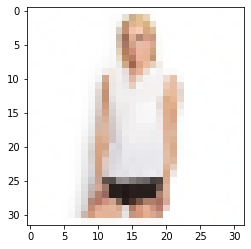

In [29]:
img1 = resize_image(images_ds[30].T) + ghost
plt.imshow(img1)
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

In [30]:
eps1

array([[-1.7576221 ,  0.81702644,  2.3949578 , ...,  0.2968144 ,
        -0.35374132, -0.63563466]], dtype=float32)

In [31]:
eps_white = eps1 + np.mean([green_direction, blue_direction, red_direction], axis=0)*3 + white_top_direction*1.5

# eps_white = eps1+np.max([green_direction, red_direction, blue_direction], axis=0)
x_hat = model.decode(y, eps_white)

x_hat[0].shape

plt.imshow((x_hat[0]))

NameError: name 'white_top_direction' is not defined

In [ ]:
eps_white = eps1 + red_direction*1 - (white_top_direction*0) + blue_direction*1 + green_direction*1 + white_top_direction*1.2
x_hat = model.decode(y, eps_white)

x_hat[0].shape

plt.imshow((x_hat[0]))
plt.imsave("red_transformation.png",x_hat[0])

# num_rows = 5
num_cols = 5
offset = 125
fig, axes = plt.subplots(num_rows, num_rows, figsize=(25, 25))
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_rows + j + offset
        img = resize_image(images_ds[index].T) + ghost
        axes[i, j].set_title('{}'.format(index))
        axes[i, j].imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

21


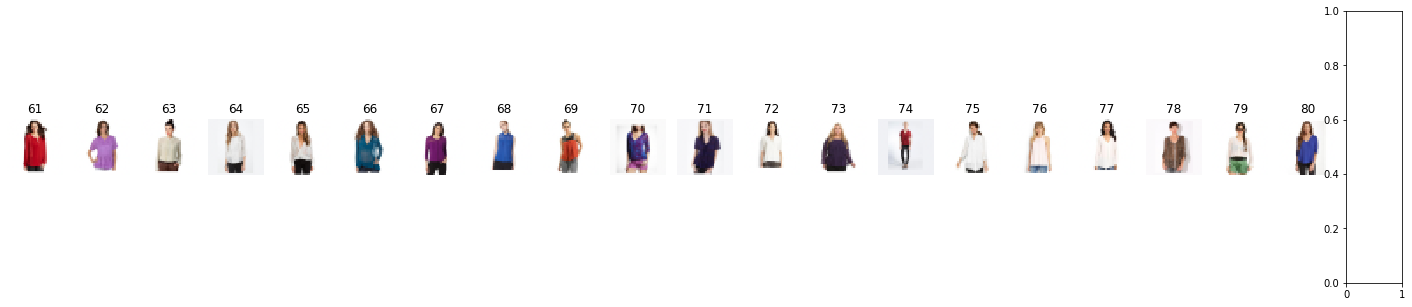

In [87]:
fig, axes = plt.subplots(1, 21, figsize=(25, 5))
for i in range(61,81):
    img1 = resize_image(images_ds[i].T) + ghost
    axes[i-61].set_title('{}'.format(i))
    axes[i-61].imshow(img1)
    axes[i-61].axis('off')
    
white_labels = np.array([1,2,8,15,30,33,39,41,42,45,51,54,60,64,65,72,75,76,77,79])
black_labels = np.array([0,7,16,20,27,29,31,36,37,43,46,50,57,58])
tanktop_labels = np.array([22,28,45,32,54,68,69,76,92,93,98,99,100,102,113,114,115,118,123,127,138])
print(len(tanktop_labels))


    

#### Getting average encoding for 'top is white' labels

In [88]:
img1 = img1[None,:]
y = np.zeros([1],dtype=np.int32)
eps1 = model.encode(img1*255,y)

In [89]:
eps1.shape

(1, 3072)

In [90]:
num_whites = white_labels.shape[0]
white_encodings = np.zeros((num_whites,eps1.shape[1]))

for idx,label_idx in enumerate(white_labels):

    img_white = resize_image(images_ds[label_idx].T) + ghost
    img_white = img_white[None, :]

    y = np.zeros([1], dtype=np.int32)

    emb = model.encode(img_white*255, y)
    white_encodings[idx,:] = emb

In [91]:
white_encodings_avg = np.mean(white_encodings,0)

#### Getting average encoding for negative examples (with respect to 'top is white')

In [92]:
set_whites = set(white_labels)
set_others = set(range(0,81)) - set_whites
non_white_labels = np.array(list(set_others))

In [93]:
non_white_labels

array([ 0,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 40,
       43, 44, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63,
       66, 67, 68, 69, 70, 71, 73, 74, 78, 80])

In [94]:

num_non_whites = non_white_labels.shape[0]
non_white_encodings = np.zeros((num_non_whites,eps1.shape[1]))

for idx,label_idx in enumerate(non_white_labels):

    img_non_white = resize_image(images_ds[label_idx].T) + ghost
    img_non_white = img_non_white[None, :]

    y = np.zeros([1], dtype=np.int32)

    emb = model.encode(img_non_white*255, y)
    non_white_encodings[idx,:] = emb

In [95]:
non_white_encodings_avg = np.mean(non_white_encodings,0)

In [96]:
white_top_direction = white_encodings_avg - non_white_encodings_avg 

In [97]:
white_top_direction

array([ 0.4827183 , -0.20933849, -0.10609876, ...,  0.40436924,
       -0.06424783,  0.33373528])

#### Trying out manipulations

In [98]:
np.save('white_top_direction.npy', white_top_direction)

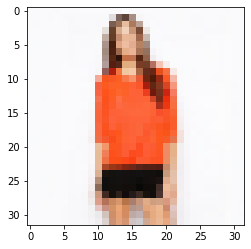

In [151]:
img1 = resize_image(images_ds[108].T) + ghost
plt.imshow(img1)
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

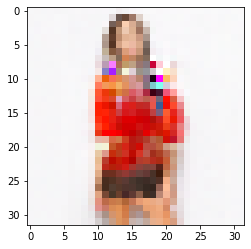

In [152]:
eps_white = eps1 + white_top_direction * -1.5
x_hat = model.decode(y, eps_white)

x_hat[0].shape

plt.imshow((x_hat[0]))

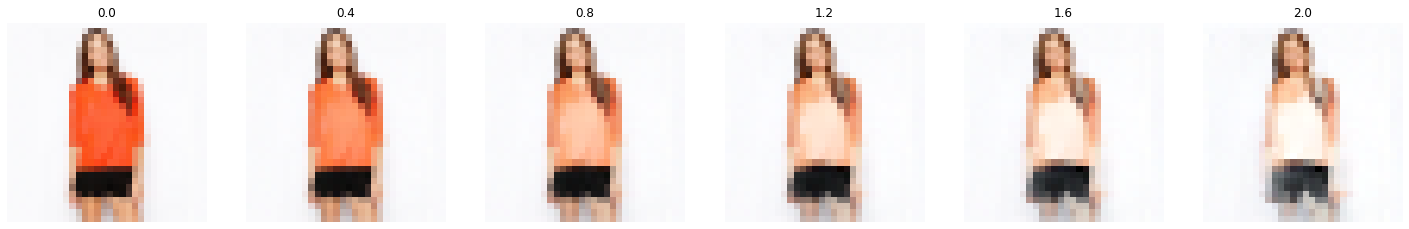

In [153]:
fig, axes = plt.subplots(1, 6, figsize=(25, 5))
for i in range(6):
    eps = eps1 + white_top_direction * i/2.5
    x_hat = model.decode(y, eps)
    axes[i].set_title('{:.1f}'.format(i*.4))
    axes[i].imshow(x_hat[0])
    axes[i].axis('off')

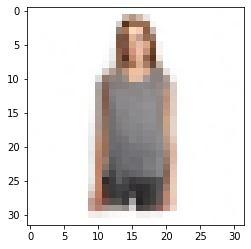

In [47]:
img1 = resize_image(images_ds[50].T) + ghost
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

img2 = resize_image(images_ds[30].T) + ghost
img2 = img2[None, :]

y = np.zeros([1], dtype=np.int32)

eps2 = model.encode(img2*255, y)

direction = eps2 - eps1
eps3 = eps1 + direction * .5
x_hat = model.decode(y, eps3)

x_hat[0].shape

plt.imshow((x_hat[0]))

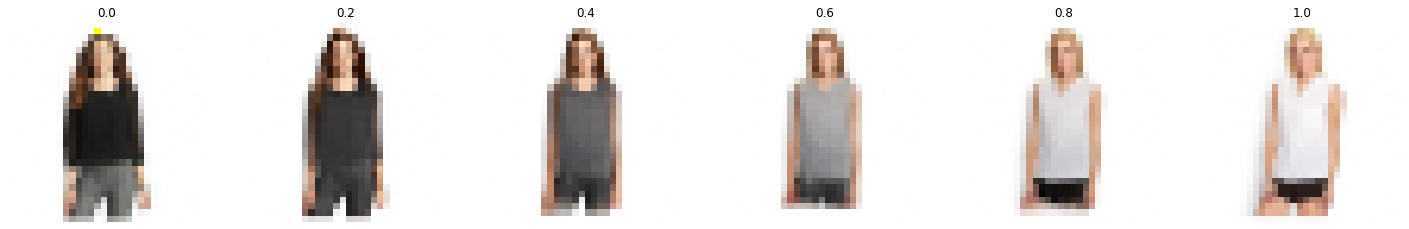

In [48]:
fig, axes = plt.subplots(1, 6,figsize=(25, 5))
for i in range(6):
    eps = eps1 + direction * i/5 
    x_hat = model.decode(y, eps)
    axes[i].set_title('{:.1f}'.format(i*.2))
    axes[i].imshow(x_hat[0])
    axes[i].axis('off')

In [102]:
img1 = img1[None,:]
y = np.zeros([1],dtype=np.int32)
eps1 = model.encode(img1*255,y)

ValueError: Cannot feed value of shape (1, 1, 32, 32, 3) for Tensor 'input/image:0', which has shape '(?, 32, 32, 3)'

In [ ]:
eps1.shape

In [103]:
num_tanktops = tanktop_labels.shape[0]
tanktop_encodings = np.zeros((num_tanktops,eps1.shape[1]))

for idx,label_idx in enumerate(tanktop_labels):

    img_tank = resize_image(images_ds[label_idx].T) + ghost
    img_tank = img_tank[None, :]

    y = np.zeros([1], dtype=np.int32)

    emb = model.encode(img_tank*255, y)
    tanktop_encodings[idx,:] = emb

In [104]:
tanktop_encodings

array([[-0.31753811,  1.61346984,  1.45794201, ...,  0.49548078,
         1.87058699, -0.90595627],
       [-0.01209571, -0.19864616,  1.55546534, ...,  0.22286919,
         0.06037294, -0.08278164],
       [ 0.09347422,  0.30845931,  1.63610232, ...,  1.48175859,
         1.43057108, -0.55828583],
       ...,
       [-2.26430392, -0.07086679,  2.86355662, ...,  0.14779678,
        -0.77215791,  1.23491251],
       [-0.10800133,  0.79062027,  0.58590341, ...,  1.59249187,
        -0.53355902,  0.78382576],
       [-1.31938946, -0.44809258,  0.8670578 , ..., -0.04821097,
        -0.27238038, -0.02529697]])

In [105]:
tanktop_encodings_avg = np.mean(tanktop_encodings,0)

#### Getting average encoding for negative examples (with respect to 'top is white')

In [106]:
set_tanktops = set(tanktop_labels)
set_others = set(range(0,100)) - set_tanktops
non_tanktop_labels = np.array(list(set_others))

In [107]:
non_tanktop_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74,
       75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94,
       95, 96, 97])

In [108]:

num_non_tanktop = non_tanktop_labels.shape[0]
non_tanktop_encodings = np.zeros((num_non_tanktop,eps1.shape[1]))

for idx,label_idx in enumerate(non_tanktop_labels):

    img_non_tanktop = resize_image(images_ds[label_idx].T) + ghost
    img_non_tanktop = img_non_tanktop[None, :]

    y = np.zeros([1], dtype=np.int32)

    emb = model.encode(img_non_tanktop*255, y)
    non_tanktop_encodings[idx,:] = emb

In [109]:
non_tanktop_encodings_avg = np.mean(non_tanktop_encodings,0)

In [110]:
tanktop_direction = tanktop_encodings_avg - non_tanktop_encodings_avg 

In [111]:
tanktop_direction

array([-0.24914353, -0.26149323, -0.2506276 , ...,  0.24471786,
       -0.37288272, -0.23935325])

#### Trying out manipulations

In [ ]:
np.save('tanktop_top_direction.npy', tanktop_direction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


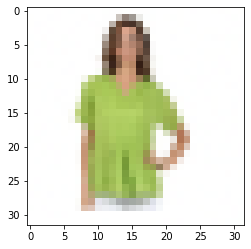

In [126]:
img1 = resize_image(images_ds[23].T) + ghost
plt.imshow(img1)
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

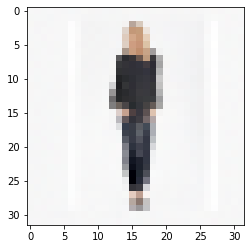

In [123]:
eps_white = eps1 + tanktop_direction 
x_hat = model.decode(y, eps_white)

x_hat[0].shape

plt.imshow((x_hat[0]))

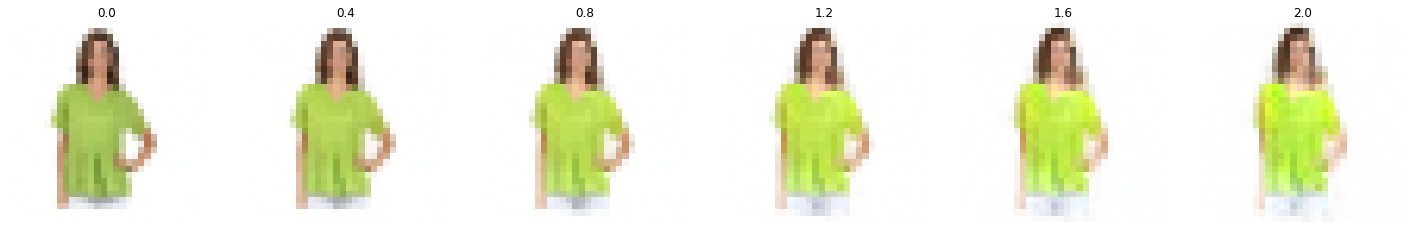

In [127]:
fig, axes = plt.subplots(1, 6, figsize=(25, 5))
for i in range(6):
    eps = eps1 + tanktop_direction * i/2.5
    x_hat = model.decode(y, eps)
    axes[i].set_title('{:.1f}'.format(i*.4))
    axes[i].imshow(x_hat[0])
    axes[i].axis('off')

In [ ]:
img1 = resize_image(images_ds[50].T) + ghost
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

img2 = resize_image(images_ds[30].T) + ghost
img2 = img2[None, :]

y = np.zeros([1], dtype=np.int32)

eps2 = model.encode(img2*255, y)

direction = eps2 - eps1
eps3 = eps1 + direction * .5
x_hat = model.decode(y, eps3)

x_hat[0].shape

plt.imshow((x_hat[0]))

In [ ]:
fig, axes = plt.subplots(1, 6,figsize=(25, 5))
for i in range(6):
    eps = eps1 + direction * i/5 
    x_hat = model.decode(y, eps)
    axes[i].set_title('{:.1f}'.format(i*.2))
    axes[i].imshow(x_hat[0])
    axes[i].axis('off')

In [218]:
a = tf.random_uniform((10,))

In [235]:
samples = model.sample(y,[.8]*1)

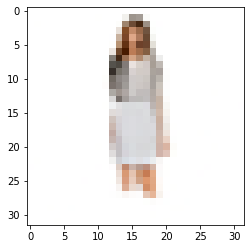

In [236]:
plt.imshow(samples[0])

In [258]:
for _ in range(1000):
    img_sampled =  model.sample(y,[.8]*1)
    samples = np.concatenate((samples,img_sampled))
    

In [256]:
np.save("samples",samples)

In [257]:
samples.shape

(2001, 32, 32, 3)